In [4]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.patches as mpatches
import os
from sklearn.externals import joblib
style.use('ggplot')


### Prepare Dataset

In [7]:

my_word = ENGLISH_STOP_WORDS

POS_TRAIN_PATH = './dataset/aclImdb/train/pos/'
NEG_TRAIN_PATH = './dataset/aclImdb/train/neg/'
pos_files = os.listdir(POS_TRAIN_PATH)
neg_files = os.listdir(NEG_TRAIN_PATH)
print('Docs prep....')

pos_lines = []
neg_lines = []
for file in pos_files:
    with open(POS_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        pos_lines.extend(lines)
for file in neg_files:
    with open(NEG_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        neg_lines.extend(lines)

docs = []
docs.extend(pos_lines)
docs.extend(neg_lines)
print('Vectorize...')
vectorizer2 = TfidfVectorizer(stop_words=my_word, max_features=300)
vectorizer2.fit(docs)
print('Vectorization done')

input_data2 = vectorizer2.transform(docs).todense()
print(input_data2.shape)
df2 = pd.DataFrame(input_data2)

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

labels2 = []
labels2 = np.append(pos_labels, neg_labels)
df2['labels'] = labels2
# df2.to_csv('data/aclImdb/processed_input_labelled3.csv')

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

X = df2.drop('labels', axis=1)
X = np.array(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, df2['labels'], random_state=20)




Docs prep....
Vectorize...
Vectorization done
(25000, 300)
(25000, 300)


### Save Vectorizer

In [134]:
if not os.path.exists('./models'):
    os.makedirs('./models')
joblib.dump(vectorizer2, './models/vectorizer.pkl')

['./models/vectorizer.pkl']

### Create NN

In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.ln0 = nn.Linear(input_size, 15)
        self.ln1 = nn.Linear(15, output_size)
        

    def forward(self, x):
        output = F.relu(self.ln0(x))
        output = F.tanh(self.ln1(output))
        return output
print(SimpleNN(X_train.shape[1],2))


SimpleNN (
  (ln0): Linear (300 -> 15)
  (ln1): Linear (15 -> 2)
)


### Train and Evaluate

SimpleNN (
  (ln0): Linear (300 -> 15)
  (ln1): Linear (15 -> 2)
)
Epoch 0 loss 0.6939151883125305
Test acc: 0.75184
Epoch 10 loss 0.5168853402137756
Test acc: 0.78464
Epoch 20 loss 0.45991280674934387
Test acc: 0.80672
Epoch 30 loss 0.4393496811389923
Test acc: 0.81456
Epoch 40 loss 0.4294993579387665
Test acc: 0.8168
Epoch 50 loss 0.4242391884326935
Test acc: 0.81504
Epoch 60 loss 0.4187297224998474
Test acc: 0.81664
Epoch 70 loss 0.4145442843437195
Test acc: 0.81744
Epoch 80 loss 0.41179516911506653
Test acc: 0.81712
Epoch 90 loss 0.40946707129478455
Test acc: 0.81792


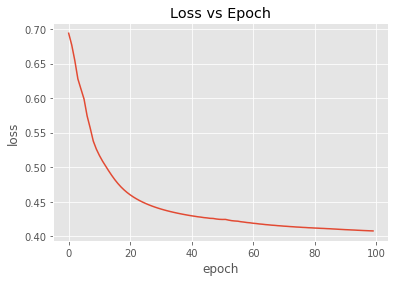

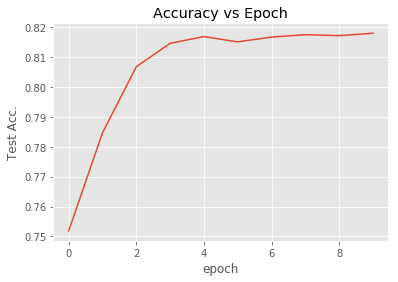

Final Test accuracy 0.820


In [215]:
net = SimpleNN(X_train.shape[1], 2)
print(net)

def evaluate(X_test,y_test):
    total = len(X_test)
    correct = 0.0
    net.eval()

    for val_x, val_y in zip(X_test, y_test):

        t_x = np.array(val_x).astype(np.float32)
        output = net(Variable(torch.from_numpy(np.array([t_x]))))[0]

        out = output.data.numpy()
        if val_y == 0:

            if not np.argmax(out):
                correct += 1


        if val_y == 1:

            if np.argmax(out):
                correct += 1

#     print('Test accuracy %.3f' % (correct / total))
    return correct / total

epochs = 100
learning_rate = 5e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate)
losses = []
acc = []
epoch_ = []
for epoch in range(epochs):
    net.train()
    inputs = Variable(torch.from_numpy(np.array(X_train).astype(np.float32)))
    targets = Variable(torch.from_numpy(np.array(y_train).astype(np.float32)).long())
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
        
    if epoch % 10 == 0:
        print('Epoch %d loss %s' % (epoch, loss.data[0]))
        test_acc = evaluate(X_test, y_test)
        acc.append(test_acc)
        print('Test acc:', test_acc)

    losses.append(loss.data[0])

plt.title('Loss vs Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses)
plt.show()

plt.title('Accuracy vs Epoch')
plt.xlabel('epoch')
plt.ylabel('Test Acc.')
plt.plot(acc)
plt.show()

print('Final Test accuracy %.3f' % evaluate(X_test, y_test))



### SAVE MODEL

In [137]:
MODELS_DIR = './models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
torch.save(net.state_dict(), MODELS_DIR + '/sentiment.pt')

### Load Model

In [5]:
vectorizer = joblib.load('./models/vectorizer.pkl')

In [10]:
model = SimpleNN(300, 2)
model.load_state_dict(torch.load('./models/sentiment.pt'))

### TEST LINE

In [12]:

def test_line(line, vectorizer, model):
    
    t_x = vectorizer.transform([line]).todense().astype(np.float32)

    t_x = np.array([t_x]).reshape(1,-1)

    model.eval()
    out = model(Variable(torch.from_numpy(t_x)))
    val = out.data.numpy()

    
    if not np.argmax(val):
        return 'Positive'
    elif np.argmax(val):
        return 'Negative'
    
print(test_line('Gov to create new policies for the betterment of farmers', vectorizer, model))
print(test_line('2 people died in plane crash',vectorizer, model))

Positive
Negative


### TIME TO CRAWL

In [69]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd


In [70]:
class Crawler(object):
    """ Specifically for scraping from HT , since the url allows scraping  : respect robots.txt XD """
    
    def __init__(self, url:str,path_to_save:str):
        self.url = url
        self.bsObj = None
        self.links = None
        self.path  = path_to_save + '.txt'
    
    def crawl(self)->list:
        self.bsObj = BeautifulSoup(urlopen(self.url), 'html.parser')
        links = []
        for value in self.bsObj.find_all('div', {'class':'media-body'}):

            links.append((value.find('span',{"class":"time-dt"}).text,value.find('a').attrs['href'],value.find('a').text))
        self.links = links
        return self.links
    
    def save(self)->None:
        if self.path:
            if self.links:
                df = pd.DataFrame(self.links)
                df.to_csv(self.path)
            else:
                print('Crawl before save')
        else:
            print('Select path to save')
    
    def get_article(self, link:str, path:str):
        self.bsObj = BeautifulSoup(urlopen(link))
        


### SAVE ARTICLES

In [1]:

CITIES = ['delhi-news','kolkata', 'mumbai', 'pune-news', 'lucknow', 'mumbai-news']
SEPARATOR = '\n*****\n'

In [95]:

url = 'http://www.hindustantimes.com/'
if not os.path.exists('./links'):
    os.makedirs('./links/')
ARTICLE_DIR = './articles/'
data = []
for city  in CITIES:
    query_url = url+city
    crawler = Crawler(query_url,'./links/'+city)
    links = crawler.crawl()
    print('Crawling articles of '+ city + '.....')


    for link in links:

        bsobj = BeautifulSoup(urlopen(link[1]),'html.parser')

        para = bsobj.find_all('p')
        para_text = ''
        for text in para:
            para_text += text.text
        if not os.path.exists('articles'):
            os.makedirs(ARTICLE_DIR)
        
        with open(ARTICLE_DIR+city+'.txt', 'a') as f:
            f.writelines(para_text)
            f.write(SEPARATOR)
    


Crawling articles of delhi-news.....
Crawling articles of kolkata.....
Crawling articles of mumbai.....
Crawling articles of pune-news.....
Crawling articles of lucknow.....
Crawling articles of mumbai-news.....


### SAVE TITLES


In [96]:
"""
    should be combined with above but doing separately for readability and understanding
"""
for city  in CITIES:
    query_url = url+city
    crawler = Crawler(query_url,'./links/'+city)
    links = crawler.crawl()
    print('Crawling articles of '+ city + '.....')
    print(len(links))
    crawler.save()

Crawling articles of delhi-news.....
48
Crawling articles of kolkata.....
48
Crawling articles of mumbai.....
48
Crawling articles of pune-news.....
48
Crawling articles of lucknow.....
48
Crawling articles of mumbai-news.....
48


## Analysis

#### Sentiment

In [9]:
delhi_df = pd.read_csv('./links/delhi-news.txt')
delhi_df.columns = ['index', 'timestamp', 'link', 'title']



In [13]:
sentiment_vals = []

for title in delhi_df['title']:
    if test_line(title, vectorizer, model) == 'Positive':
        sentiment_vals.append(1)
    else:
        sentiment_vals.append(0)

delhi_df['sentiment'] = sentiment_vals

In [14]:
def percent_positive(df):
    """    Return percent positive
          df: pd.DataFrame : link dataframe of city
    """
    percent_positive = (df.sentiment.sum()/ len(df)*1.0 )
    return (percent_positive)
percent_positive(delhi_df)

0.25

In [15]:
def get_link_df(city:str):
    """ Get link data frame for a particular city """
    _df = pd.read_csv('./links/'+city+'.txt')
    _df.columns = ['index', 'timestamp', 'link', 'title']
    return _df


In [16]:
def get_headline_sentiment(city:str)->pd.DataFrame:
    """ Returns dataframe with sentiment corresponding to news titles """
    _df = pd.read_csv('./links/'+city+'.txt')
    _df.columns = ['index', 'timestamp', 'link', 'title']
    sentiment_vals = []

    for title in _df['title']:
        if test_line(title, vectorizer, model) == 'Positive':
            sentiment_vals.append(1)
        else:
            sentiment_vals.append(0)

    _df['sentiment'] = sentiment_vals
    return _df

##### Find positive % percent for cities and analyse 

In [183]:
df_list = [get_headline_sentiment(city) for city in CITIES]

In [188]:
sentiment = []
for city_df in df_list:
    sentiment.append(percent_positive(city_df))

In [202]:
print(sentiment)

[0.25, 0.22916666666666666, 0.4375, 0.25, 0.125, 0.4375]


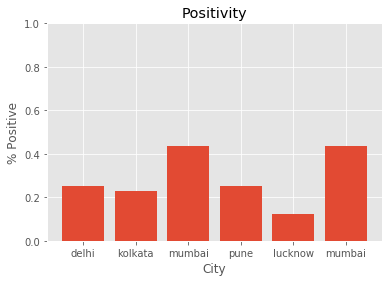

In [211]:
city_vals = [city.split('-')[0] for city in CITIES]
city_index = [i for i in range(len(CITIES))]

plt.title('Positivity')
plt.xlabel('City')
plt.ylabel('% Positive')
plt.bar(city_index, sentiment)
plt.xticks(city_index, city_vals)
plt.ylim((0.0, 1.0))
plt.show()

In [227]:
SEPARATOR = '\n*****\n'

In [17]:
def get_articles(city:str)->list:
    """ Read article file and return the article text    """
    with open('./articles/'+city+'.txt') as f:
        lines =''.join( f.readlines())
    lines = [line for line in lines.split(SEPARATOR) if line]
    return lines

# def analyze_articles(city):
#     lines = get_articles(city)
#     print(len(lines))

# for i in range(len(CITIES)):
#     analyze_articles(CITIES[i])

#### Polarity

In [20]:
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

In [21]:
analyser = SentimentIntensityAnalyzer()

In [22]:
def text_analyser(text:str)->float: 
    """ Return cummulative polarity for text """
    sentences = sent_tokenize(text)
    cummulative_polarity = 0.0
    for sent in sentences:
        polarity = analyser.polarity_scores(sent)['compound']
        cummulative_polarity += polarity
    return cummulative_polarity
text_analyser('It was pathetic. I did not like it')

-0.8473999999999999

In [23]:
import numpy as np

In [24]:
def polarity_variation(city:str):
    """ Get polarity for all articles pertaining to a particular city    """
    articles = get_articles(city)
    polarities = []
    for article in articles:
        polarities.append(text_analyser(article))
    return polarities
def polarity_analyser(polarities:list):
    """ Get polarity matrix for polarity vector of all articles    """
    pol_array = np.array(polarities)
    pos_polarity = [polarity for polarity in polarities if polarity>=0]
    neg_polarity = [polarity for polarity in polarities if polarity<0]
    max_pos_polarity = np.argmax(pol_array)
    max_neg_polarity = np.argmin(pol_array)
    return pos_polarity, neg_polarity, min(polarities), max_neg_polarity,max(polarities), max_pos_polarity

def plot_variation(city,polarities):
    """   Plot polarities of articles  """
    link_df = get_link_df(city)
    x_ticks = link_df.timestamp.values
    plt.title('Polarity Variation %s '% city)
    article_index = [i for i in range(len(polarities))]
    plt.bar(article_index,polarities)
#     plt.xticks(article_index, x_ticks) # not clearly visible in notebook
    plt.show()



In [404]:
%pylab inline
pylab.rcParams['figure.figsize'] = (5, 3)

Populating the interactive namespace from numpy and matplotlib


### View Polarity of articles in different cities

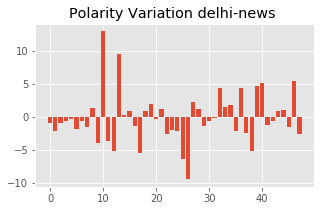

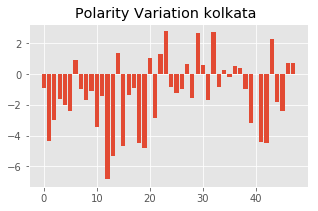

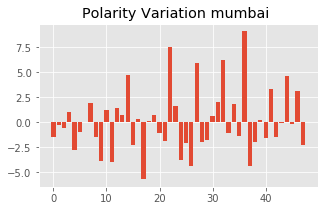

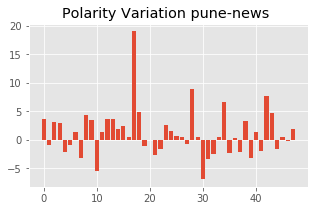

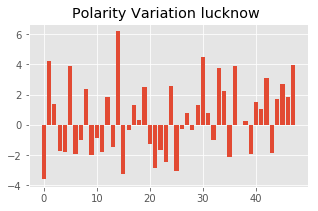

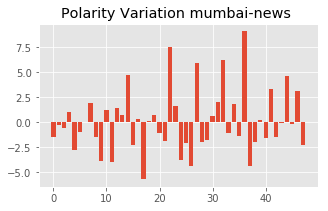

In [405]:
for i in range(len(CITIES)):
    polarities = polarity_variation(CITIES[i])
    
    plot_variation(CITIES[i], polarities)

In [333]:
"""
    For all the cities for perform the following
        1. Find article polarity metrics for a city 
        2. Find the positive and negative articles and find the features
        3. Calculate polarity averages for each city
"""

negative_keys = []
positive_keys = []
avg_pos_polarity = []
avg_neg_polarity = []
for i in range(len(CITIES)):
    
    tfidf = TfidfVectorizer(max_features=20, stop_words=ENGLISH_STOP_WORDS)
    
    polarities = polarity_variation(CITIES[i])
    pos, neg , min_val, min_index, max_val, max_index = polarity_analyser(polarities)
    articles = get_articles(CITIES[i])
    
    pos_indices = [i for i in range(len(polarities)) if polarities[i]>=0]
    neg_indices = [i for i in range(len(polarities)) if polarities[i]<0]
    neg_articles = []
    pos_articles = []
    
    for  i in neg_indices:
        neg_articles.append(articles[i])
    
    for i in pos_indices:
        pos_articles.append(articles[i])
    
    vectorized = tfidf.fit(neg_articles)
#     print('Keywords in most negative:' , vectorized.get_feature_names())
    negative_keys.append(vectorized.get_feature_names())

    vectorized = tfidf.fit(pos_articles)
#     print('Keywords in post positive', vectorized.get_feature_names())
    positive_keys.append(vectorized.get_feature_names())

    avg_pos_polarity.append(np.average(pos))
    avg_neg_polarity.append(np.average(neg))

In [407]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 5)

Populating the interactive namespace from numpy and matplotlib


##### Visualise the average positive and negative polarity 

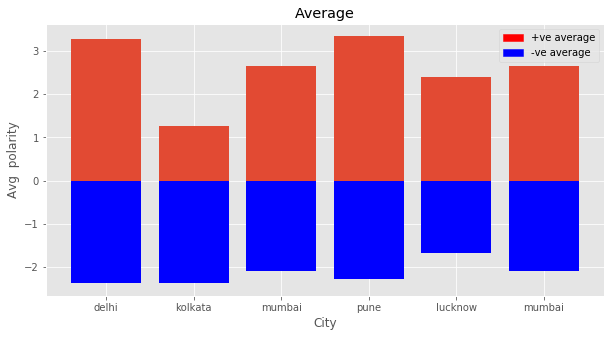

In [409]:
x_ticks =[city.split('-')[0] for city in CITIES]

city_index = [i for i in range(len(CITIES))]
plt.title('Average')
plt.xticks(city_index, x_ticks)
pos_patch = mpatches.Patch(color='red', label='+ve average')
neg_patch = mpatches.Patch(color='blue', label='-ve average')
plt.legend(handles=[pos_patch, neg_patch])
plt.bar(city_index, avg_pos_polarity)
plt.bar(city_index, avg_neg_polarity , color='b')
plt.xlabel('City')
plt.ylabel('Avg  polarity')
plt.show()

#### Find Frequency Distribution for the most important features in positive and negative articles cumulatively

In [336]:
neg_flattened = []
for part in negative_keys:
    for word in part:
        neg_flattened.append(word)
neg_freq =  {}
for word in neg_flattened:
    if word not in neg_freq:
        neg_freq[word] = 1
    else:
        neg_freq[word] += 1
pos_flattened = []
for part in positive_keys:
    for word in part:
        pos_flattened.append(word)
pos_freq =  {}
for word in pos_flattened:
    if word not in pos_freq:
        pos_freq[word] = 1
    else:
        pos_freq[word] += 1

In [339]:
from nltk import FreqDist

In [377]:
tagged = nltk.tag.pos_tag(pos_flattened)
# print(tagged)
pos_filtered = [tag[0] for tag in tagged if tag[1][0]=='N']
tagged = nltk.tag.pos_tag(neg_flattened)
# print(tagged)
neg_filtered = [tag[0] for tag in tagged if tag[1][0]=='N']


In [379]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

Populating the interactive namespace from numpy and matplotlib


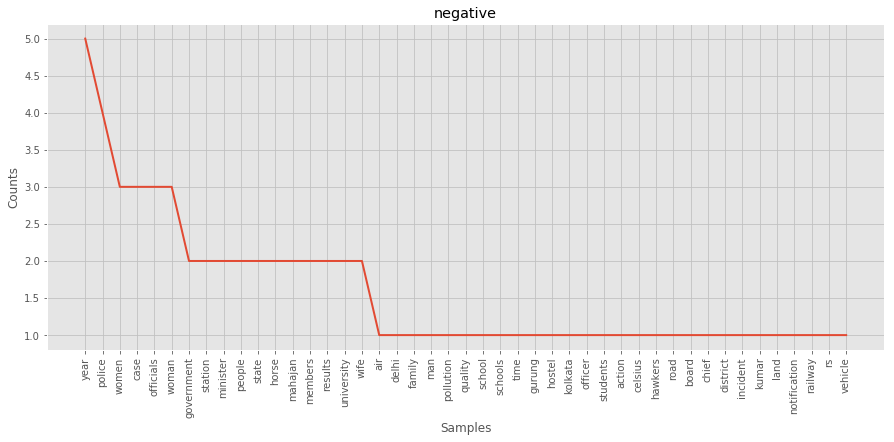

In [383]:
neg_dist = FreqDist(neg_filtered)
neg_dist.plot(title='negative')

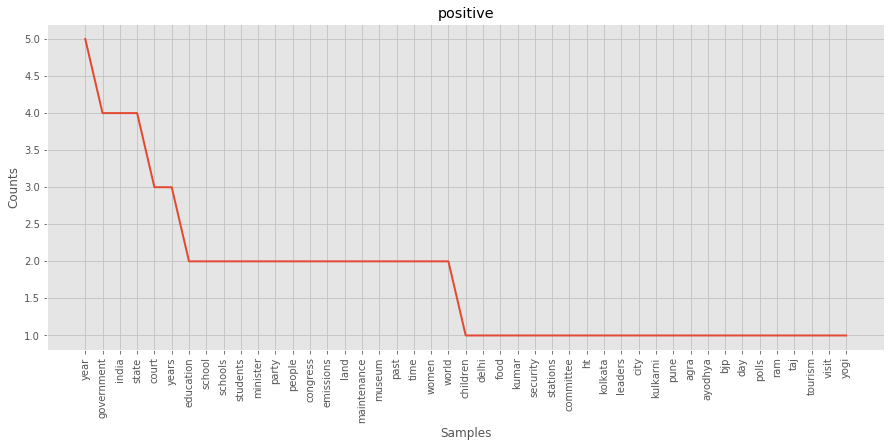

In [384]:
pos_fdist = FreqDist(pos_filtered)
pos_fdist.plot(title='positive')

In [500]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

Populating the interactive namespace from numpy and matplotlib


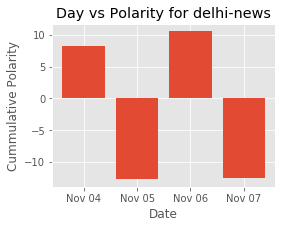

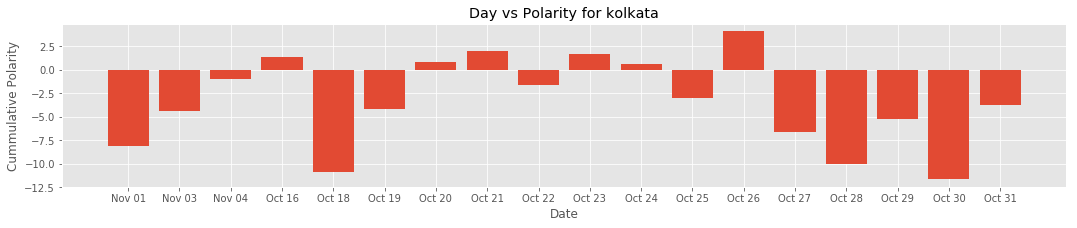

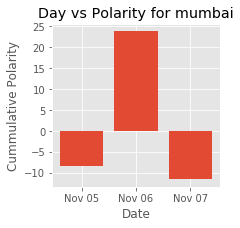

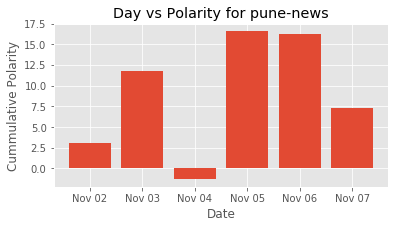

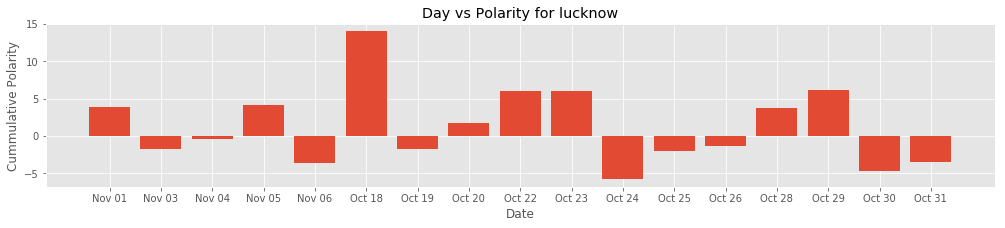

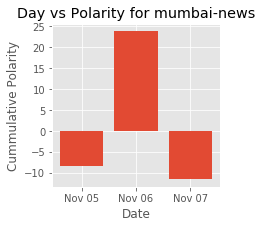

In [33]:
"""
    Different cities are at a different focal point
    thus the number of news generated within the given timespan 
    varies from city to city 
"""
df_list = []
for city in CITIES:
    articles = pd.DataFrame(get_articles(city), columns=['article'])
    links_df = get_link_df(city)
    df = pd.concat([links_df,articles], axis=1)
    compound_polarity = []
    for i in range(len(df)):
        polarity = text_analyser(df.iloc[i]['article'])
        compound_polarity.append(polarity)

    df = pd.concat([df,pd.DataFrame(compound_polarity, columns=['polarity'])], axis=1)
    
    filtered_dt = []
    for value in df['timestamp'].values:
        filtered_dt.append(value.split(',')[0])
    df = pd.concat([df, pd.DataFrame(filtered_dt, columns=['dt'])], axis=1)
    val = df.groupby(['dt']).sum()
    df_list.append(df)
    
    val = val.drop(['index'], axis=1)
#     print(val)
#     print(val.columns)
    x_ticks = val.index.values
#     print(x_ticks)
    x = [i for  i in range(len(val))]
    plt.figure(figsize=(len(x_ticks), 3))
    plt.bar(x, val['polarity'])
    plt.xticks(x, x_ticks)
    plt.title('Day vs Polarity for %s' % city)
    plt.xlabel('Date')
    plt.ylabel('Cummulative Polarity')
    plt.show()